<a href="https://colab.research.google.com/github/realxoman/PoultryInspector/blob/master/test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# مسیر دیتاست
train_val_dir = "/content/drive/MyDrive/PoultryInspector/train"  # مسیر به دایرکتوری training و validation
test_dir = "/content/drive/MyDrive/PoultryInspector/test"  # مسیر به دایرکتوری test

# تعریف ترنسفورم‌ها (پیش‌پردازش‌ها و augmentation)
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomRotation(15),  # چرخش تصادفی تا 15 درجه
        transforms.RandomResizedCrop(299, scale=(0.8, 1.0)),  # برش تصادفی و تغییر اندازه
        transforms.RandomHorizontalFlip(),  # وارونه‌سازی افقی
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # تغییر روشنایی، کنتراست و اشباع
        transforms.ToTensor(),  # تبدیل تصویر به تنسور
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # نرمال‌سازی به بازه [-1, 1]
    ]),
    "validation": transforms.Compose([
        transforms.Resize((299, 299)),  # تغییر اندازه
        transforms.ToTensor(),  # تبدیل به تنسور
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # نرمال‌سازی
    ]),
    "test": transforms.Compose([
        transforms.Resize((299, 299)),  # تغییر اندازه
        transforms.ToTensor(),  # تبدیل به تنسور
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # نرمال‌سازی
    ])
}

# تغییر پسوند فایل‌ها به حروف کوچک
def lower_case_extension(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower() != file:  # اگر پسوند فایل به حروف کوچک نیست
                os.rename(os.path.join(root, file), os.path.join(root, file.lower()))  # تغییر به حروف کوچک
    return path

# بارگذاری داده‌های آموزش و اعتبارسنجی از یک دایرکتوری (train_val_dir)
train_val_dir = lower_case_extension(train_val_dir)
test_dir = lower_case_extension(test_dir)

train_val_dataset = datasets.ImageFolder(root=train_val_dir, transform=data_transforms['train'])

# تقسیم‌بندی داده‌ها به آموزش و اعتبارسنجی (80% آموزش، 20% اعتبارسنجی)
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

# اعمال ترنسفورم‌های مناسب به هر بخش
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['validation']

# بارگذاری داده‌های تست از دایرکتوری جداگانه (test_dir)
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms['test'])

# ایجاد DataLoader برای هر بخش
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

dataloaders = {
    "train": train_loader,
    "validation": val_loader,
    "test": test_loader,
}

# تعداد نمونه‌ها در هر بخش
dataset_sizes = {'train': len(train_dataset), 'validation': len(val_dataset), 'test': len(test_dataset)}

# نام کلاس‌ها (دسته‌ها)
class_names = train_val_dataset.classes

print(f"Class names: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")

num_aug_per_epoch = len(dataloaders["train"])  # تعداد batchها در هر epoch
effective_dataset_size = 32 * dataset_sizes['train']  # تعداد تصاویر "مجازی" در هر epoch (32 = batch size)

print(f"Effective Train size (with augmentation per epoch): {effective_dataset_size}")


Class names: ['defrost', 'fresh']
Dataset sizes: {'train': 270, 'validation': 68, 'test': 47}
Effective Train size (with augmentation per epoch): 8640


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
import torch
import torch.nn as nn
from torchvision import models

# بارگذاری مدل InceptionV3 با وزن‌های پیش‌آموزش داده شده
# model = models.inception_v3(pretrained=True)
model = models.efficientnet_b0(pretrained=True)


# Freeze کردن تمام لایه‌های پیش‌آموزش داده شده
for param in model.parameters():
    param.requires_grad = True



# # تغییر لایه خروجی (fully connected layer)
# num_ftrs = model.fc.in_features  # تعداد ورودی‌های لایه fully connected
# model.fc = torch.nn.Linear(model.fc.in_features, 2)  # تنظیم برای دو کلاس

# تغییر لایه خروجی (Fully Connected Layer)
num_ftrs = model.classifier[1].in_features  # تعداد ورودی‌های لایه classifier
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 256),  # لایه میانی
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2),  # خروجی نهایی برای ۲ کلاس
    nn.Softmax(dim=1)
)

# انتقال مدل به GPU در صورت موجود بودن
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Epoch 1/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.6194 Acc: 0.7296 Recall: 0.8855 Specificity: 0.5827


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.4810 Acc: 0.8971 Recall: 1.0000 Specificity: 0.7667
Best model saved!
Epoch 2/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4429 Acc: 0.9963 Recall: 1.0000 Specificity: 0.9928


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3787 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Best model saved!
Epoch 3/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3824 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3465 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 4/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3472 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3246 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 5/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3280 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3175 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 6/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3233 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3151 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 7/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3171 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3144 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 8/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3166 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3146 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 9/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3157 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3147 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 10/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3163 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3146 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 11/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3155 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3146 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 12/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3154 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3146 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 13/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3168 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3145 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 14/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3158 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3144 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 15/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3157 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3145 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 16/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3156 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3145 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 17/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3167 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3145 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 18/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3156 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3145 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 19/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3162 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3145 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 20/20
--------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3166 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.3145 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Training complete
Best Validation Accuracy: 1.0000


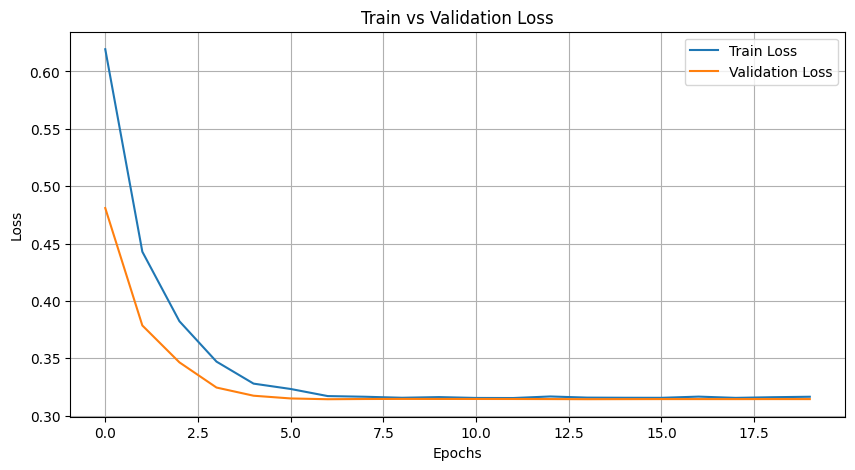

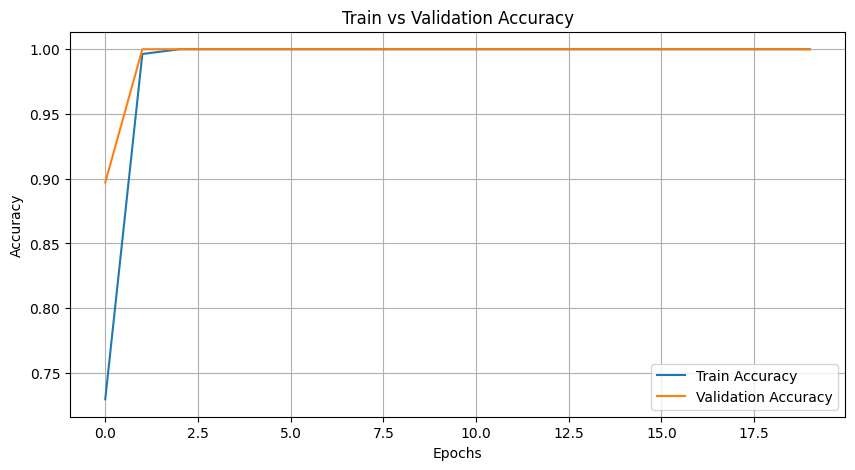

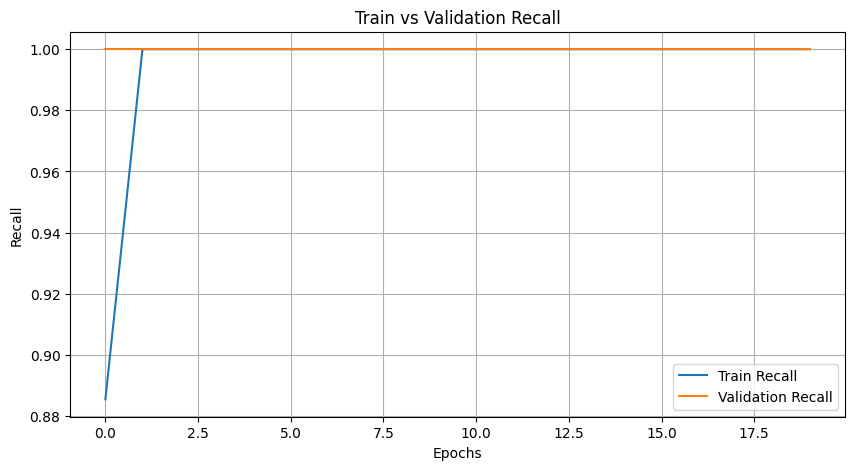

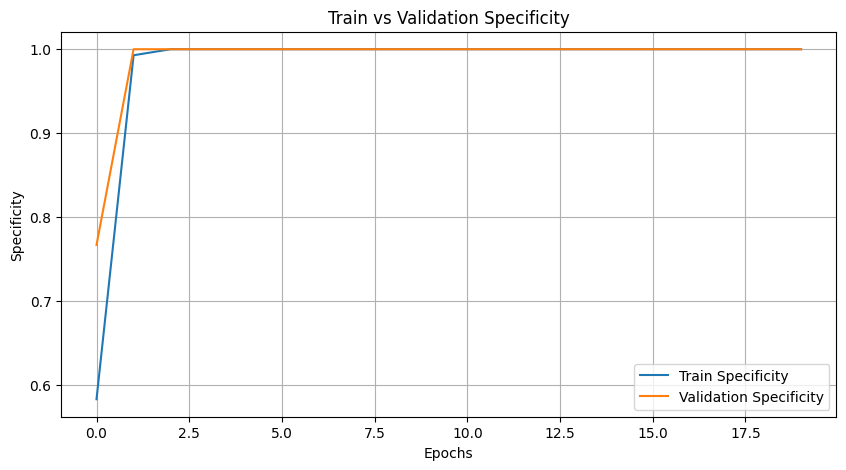

In [11]:
# تعریف تابع برای محاسبه Recall و Specificity
from sklearn.metrics import confusion_matrix

num_epochs = 20
best_accuracy = 0.0

# تعریف تابع هزینه
class_weights = [1.0, 2.0]  # وزن برای هر کلاس
weights = torch.tensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

# تعریف بهینه‌ساز (فقط لایه‌های جدید باید آپدیت شوند)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Scheduler برای کاهش نرخ یادگیری در صورت عدم پیشرفت
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



def calculate_metrics(labels, preds):
    cm = confusion_matrix(labels, preds)
    TN, FP, FN, TP = cm.ravel()

    # محاسبه معیارها
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    return recall, specificity

# ذخیره تاریخچه Loss، Accuracy، Recall و Specificity
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
train_recall_history = []
val_recall_history = []
train_specificity_history = []
val_specificity_history = []

# تابع آموزش مدل
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=20):
    global best_accuracy  # برای ذخیره بهترین مدل

    best_accuracy = 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # هر دو فاز: آموزش و اعتبارسنجی
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # مدل در حالت آموزش
            else:
                model.eval()  # مدل در حالت ارزیابی

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            # پردازش داده‌ها
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # صفر کردن گرادیان‌ها
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Forward Pass
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward Pass و بهینه‌سازی (فقط در فاز train)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # جمع‌آوری آمار
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # ذخیره پیش‌بینی‌ها و برچسب‌ها برای محاسبه Recall و Specificity
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            # تنظیم scheduler (فقط در فاز train)
            if phase == 'train':
                scheduler.step()

            # محاسبه میانگین Loss و Accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # محاسبه Recall و Specificity
            recall, specificity = calculate_metrics(all_labels, all_preds)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Recall: {recall:.4f} Specificity: {specificity:.4f}")

            # ذخیره مقادیر برای رسم نمودارها
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
                train_recall_history.append(recall)
                train_specificity_history.append(specificity)
            elif phase == 'validation':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                val_recall_history.append(recall)
                val_specificity_history.append(specificity)

            # ذخیره بهترین مدل
            if phase == 'validation' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                torch.save(model.state_dict(), 'best_efficientnet_model.pth')
                print("Best model saved!")

    print("Training complete")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# شروع آموزش
train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs)

# رسم نمودارهای Loss و Accuracy
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Recall
plt.figure(figsize=(10, 5))
plt.plot(train_recall_history, label='Train Recall')
plt.plot(val_recall_history, label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Train vs Validation Recall')
plt.legend()
plt.grid(True)
plt.show()

# Specificity
plt.figure(figsize=(10, 5))
plt.plot(train_specificity_history, label='Train Specificity')
plt.plot(val_specificity_history, label='Validation Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.title('Train vs Validation Specificity')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
model = models.efficientnet_b0(pretrained=False)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2),
    nn.Softmax(dim=1)
)
model.load_state_dict(torch.load('best_efficientnet_model.pth'))
model = model.to(device)
model.eval()


<ipython-input-13-82d1b373f885>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_efficientnet_model.pth'))


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

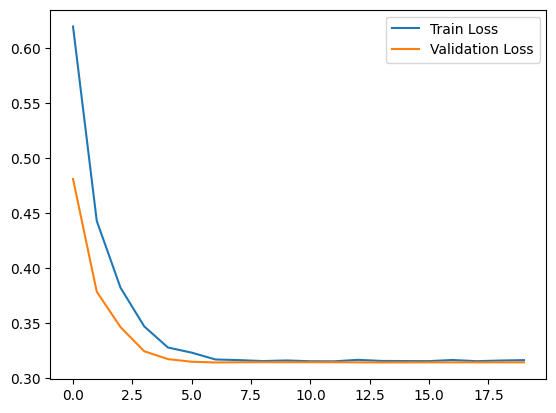

In [14]:
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()


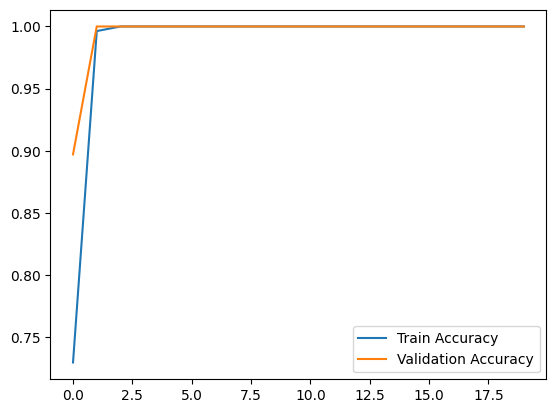

In [15]:
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.legend()
plt.show()


In [16]:
import torch
from torch import nn
from torchvision import models
from torch.utils.data import DataLoader

# فرض می‌کنیم که DataLoader داده‌های تست در دسترس است
# test_loader قبلاً تعریف شده و شامل داده‌های تست است

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# بارگذاری مدل با وزن‌ها
model = models.efficientnet_b0(pretrained=False)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2),
    nn.Softmax(dim=1)
)
model.load_state_dict(torch.load('best_efficientnet_model.pth'))
model = model.to(device)
model.eval()  # تنظیم مدل به حالت ارزیابی

# متغیرهایی برای محاسبه دقت
correct = 0
total = 0

# بدون محاسبه گرادیان (برای تست فقط پیش‌بینی می‌کنیم)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # پیش‌بینی از مدل
        outputs = model(inputs)

        # انتخاب کلاس با بیشترین احتمال
        _, predicted = torch.max(outputs, 1)

        # شمارش تعداد درست پیش‌بینی‌ها
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# محاسبه دقت
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')


<ipython-input-16-57b00bb8f0bb>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_efficientnet_model.pth'))
/usr/local/lib/python3.10/

Accuracy of the model on the test set: 97.87%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

       fresh       1.00      0.97      0.98        30
     defrost       0.94      1.00      0.97        17

    accuracy                           0.98        47
   macro avg       0.97      0.98      0.98        47
weighted avg       0.98      0.98      0.98        47



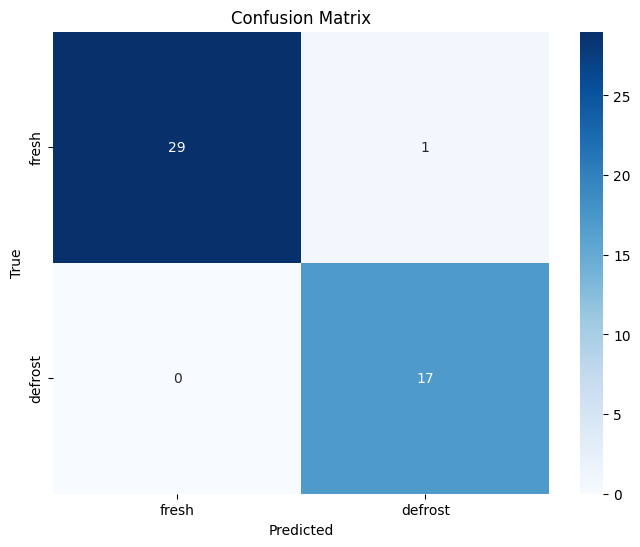

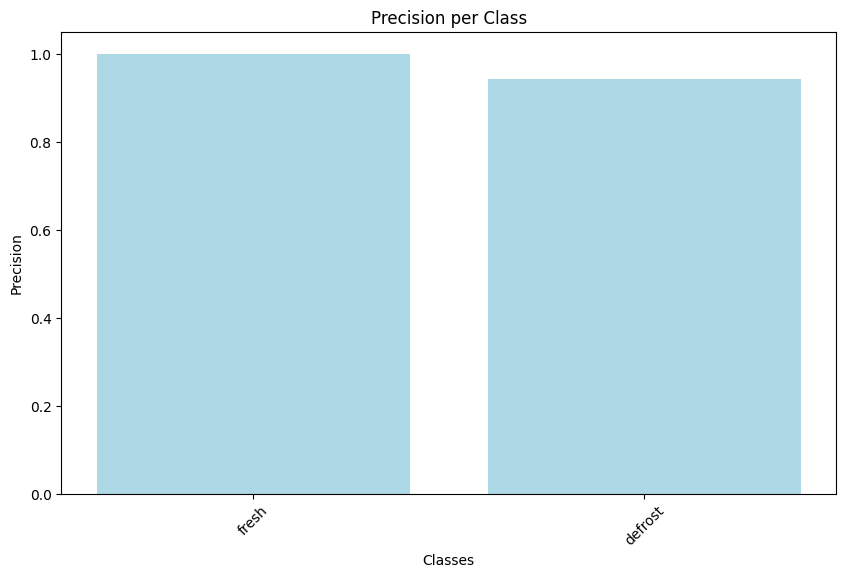

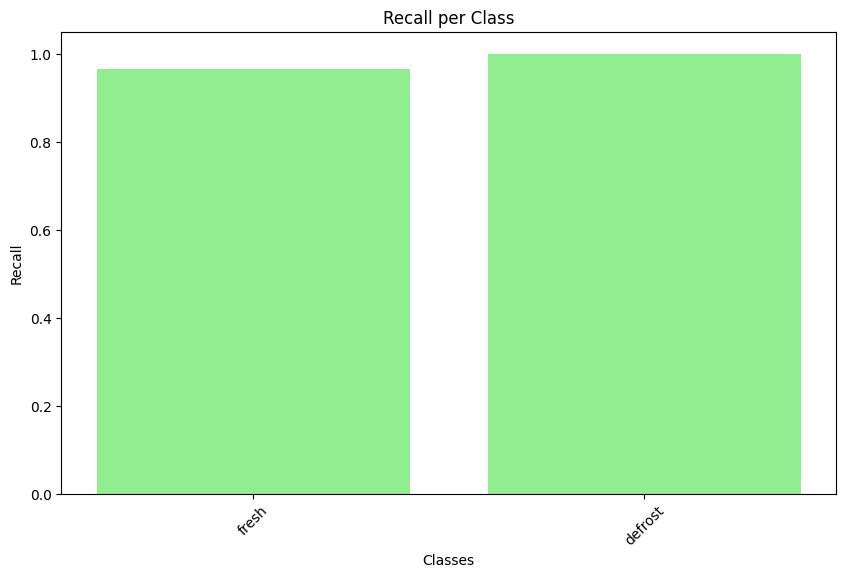

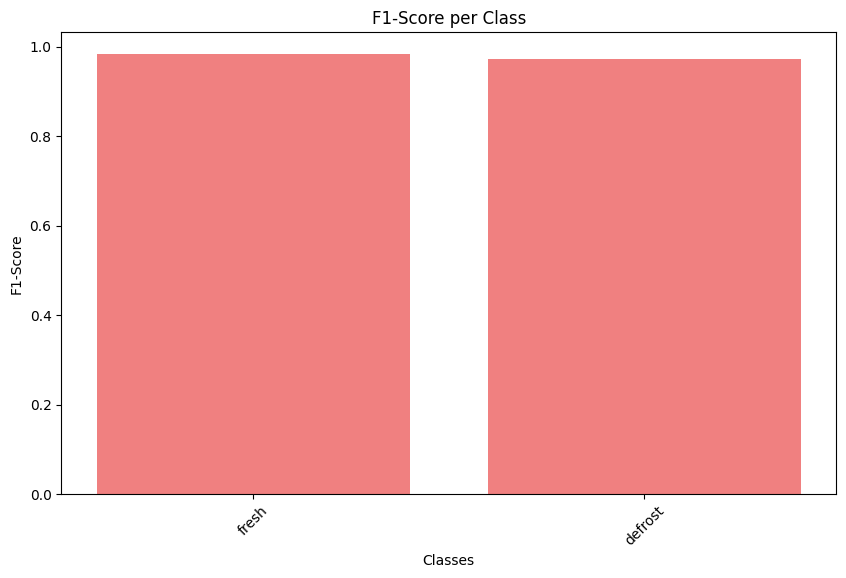

In [22]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# فرض بر این است که مدل شما و داده‌های تست قبلاً بارگذاری شده‌اند و آماده هستند.

# متغیرهای ذخیره پیش‌بینی‌ها و برچسب‌های صحیح
true_labels = []
predictions = []

model.eval()  # مدل را در حالت ارزیابی قرار می‌دهیم

# پیش‌بینی روی داده‌های تست
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # پیش‌بینی‌ها از مدل
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # ذخیره برچسب‌های صحیح و پیش‌بینی‌ها
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# گزارش classification_report
report = classification_report(true_labels, predictions, target_names=class_names)
print("Classification Report:\n", report)

# ترسیم confusion matrix
cm = confusion_matrix(true_labels, predictions)

# رسم confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ترسیم نمودارهای متریک‌ها
# استخراج متریک‌ها از گزارش classification_report
report_dict = classification_report(true_labels, predictions, target_names=class_names, output_dict=True)

# دقت، بازیابی و F1-Score را برای هر کلاس استخراج می‌کنیم
precision = [report_dict[class_name]['precision'] for class_name in class_names]
recall = [report_dict[class_name]['recall'] for class_name in class_names]
f1_score = [report_dict[class_name]['f1-score'] for class_name in class_names]

# رسم نمودار دقت
plt.figure(figsize=(10, 6))
plt.bar(class_names, precision, color='lightblue')
plt.title('Precision per Class')
plt.xlabel('Classes')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.show()

# رسم نمودار بازیابی
plt.figure(figsize=(10, 6))
plt.bar(class_names, recall, color='lightgreen')
plt.title('Recall per Class')
plt.xlabel('Classes')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.show()

# رسم نمودار F1-Score
plt.figure(figsize=(10, 6))
plt.bar(class_names, f1_score, color='lightcoral')
plt.title('F1-Score per Class')
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.show()


<ipython-input-33-468f9fdaf0b9>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_efficientnet_model.pth'))


Predicted class: defrost


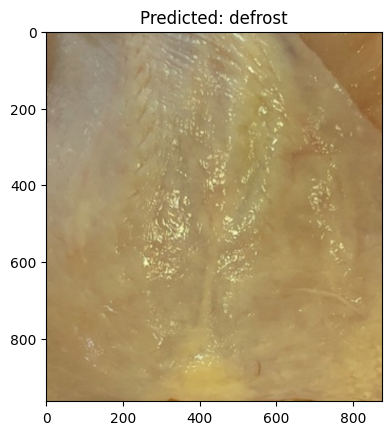

In [33]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# تنظیم device (cuda یا cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# بارگذاری مدل با وزن‌ها
model = models.efficientnet_b0(pretrained=False)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2),
    nn.Softmax(dim=1)
)
model.load_state_dict(torch.load('best_efficientnet_model.pth'))
model = model.to(device)
model.eval()  # تنظیم مدل به حالت ارزیابی

# تعریف ترنسفورم‌ها (پیش‌پردازش‌ها)
data_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  # تغییر اندازه
    transforms.ToTensor(),  # تبدیل به تنسور
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # نرمال‌سازی
])

# بارگذاری و پیش‌پردازش تصویر تست
img_path = "/content/drive/MyDrive/PoultryInspector/222.jpg"  # مسیر تصویر تست
img = Image.open(img_path)  # بارگذاری تصویر
img = data_transforms(img).unsqueeze(0)  # اعمال پیش‌پردازش‌ها و اضافه کردن بعد batch

# انتقال تصویر به device (cuda یا cpu)
img = img.to(device)

# پیش‌بینی با مدل
with torch.no_grad():
    outputs = model(img)
    _, predicted = torch.max(outputs, 1)  # گرفتن برچسب کلاس با بیشترین احتمال
    predicted_class = predicted.item()  # تبدیل به عدد

# نمایش نتایج
class_names = ['defrost', 'fresh']  # نام کلاس‌ها
print(f"Predicted class: {class_names[predicted_class]}")

# اگر نیاز به نمایش تصویر دارید
img = Image.open(img_path)
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.show()
